In [1]:
# author: hemingdeng

# 1 模拟数据生成

import numpy as np
import pandas as pd

# 设置随机数种子以保持结果的一致性
np.random.seed(42)

# 定义样本数量
n_control = 300  # 对照组样本量
n_treatment = 100  # 实验组样本量
n_total = n_control + n_treatment

# 生成10个混淆变量
confounders = np.random.normal(0, 1, (n_total, 10))

# 为混淆变量创建DataFrame
df_confounders = pd.DataFrame(confounders, columns=[f'confounder_{i+1}' for i in range(10)])

# 生成处理分组（实验组=1，对照组=0），按照1:3的比例
treatment = np.concatenate([np.ones(50), np.zeros(300), np.ones(50)])

# 生成结局变量（0或1）
outcome = np.random.binomial(1, 0.5, n_total)

# 将处理分组和结局变量添加到混淆变量DataFrame中
df_data = pd.concat([df_confounders, pd.Series(treatment, name='treatment'), pd.Series(outcome, name='outcome')], axis=1)

df = df_data
df['treatment'] = df['treatment'].astype(int)

In [2]:
# 2 特征选择

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score

# 将数据分为训练集和测试集
X = df.drop(['treatment', 'outcome'], axis=1)
y = df['outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost
model_xgb = xgb.XGBClassifier()
model_xgb.fit(X_train, y_train)
f1_xgb = f1_score(y_test, model_xgb.predict(X_test))
auc_xgb = roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:, 1])
print(f"XGBoost F1-Score: {f1_xgb}, AUC: {auc_xgb}")

# 随机森林
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
f1_rf = f1_score(y_test, model_rf.predict(X_test))
auc_rf = roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1])
print(f"Random Forest F1-Score: {f1_rf}, AUC: {auc_rf}")

# Logistic回归
model_logit = LogisticRegression()
model_logit.fit(X_train, y_train)
f1_logit = f1_score(y_test, model_logit.predict(X_test))
auc_logit = roc_auc_score(y_test, model_logit.predict_proba(X_test)[:, 1])
print(f"Logistic Regression F1-Score: {f1_logit}, AUC: {auc_logit}")

# GBDT
model_gbdt = GradientBoostingClassifier()
model_gbdt.fit(X_train, y_train)
f1_gbdt = f1_score(y_test, model_gbdt.predict(X_test))
auc_gbdt = roc_auc_score(y_test, model_gbdt.predict_proba(X_test)[:, 1])
print(f"GBDT F1-Score: {f1_gbdt}, AUC: {auc_gbdt}")

# LightGBM
model_lgbm = lgb.LGBMClassifier(verbose = -1)
model_lgbm.fit(X_train, y_train)
f1_lgbm = f1_score(y_test, model_lgbm.predict(X_test))
auc_lgbm = roc_auc_score(y_test, model_lgbm.predict_proba(X_test)[:, 1])
print(f"LightGBM F1-Score: {f1_lgbm}, AUC: {auc_lgbm}")

# 计算特征重要性并排序
def get_feature_importance(model, feature_names):
    if isinstance(model, xgb.XGBClassifier):
        importance = model.feature_importances_
    elif isinstance(model, RandomForestClassifier):
        importance = model.feature_importances_
    elif isinstance(model, LogisticRegression):
        importance = model.coef_[0]
    elif isinstance(model, GradientBoostingClassifier):
        importance = model.feature_importances_
    elif isinstance(model, lgb.LGBMClassifier):
        importance = model.feature_importances_
    else:
        raise ValueError("Unsupported model type")
    
    sorted_idx = np.argsort(importance)
    return [(feature_names[i], importance[i]) for i in sorted_idx]

# 输出特征重要性排序
# print("\nFeature Importance from XGBoost:")
# print(get_feature_importance(model_xgb, X.columns))
# 
# print("\nFeature Importance from Random Forest:")
# print(get_feature_importance(model_rf, X.columns))
# 
# print("\nFeature Importance from Logistic Regression:")
# print(get_feature_importance(model_logit, X.columns))
# 
# print("\nFeature Importance from GBDT:")
# print(get_feature_importance(model_gbdt, X.columns))
# 
# print("\nFeature Importance from LightGBM:")
# print(get_feature_importance(model_lgbm, X.columns))

XGBoost F1-Score: 0.5135135135135135, AUC: 0.5248271527341295
Random Forest F1-Score: 0.38235294117647056, AUC: 0.4761156505342552
Logistic Regression F1-Score: 0.411764705882353, AUC: 0.49025769956002513
GBDT F1-Score: 0.4444444444444445, AUC: 0.4607165304839724
LightGBM F1-Score: 0.47222222222222227, AUC: 0.5047140163419233


In [3]:
# 3 计算倾向性评分

X = df.drop(['treatment', 'outcome'], axis=1)
treatment = df['treatment']

# 定义模型列表（不再使用网格搜索）
models = {
    'XGBoost': xgb.XGBClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Logit': LogisticRegression(),
    'GBDT': GradientBoostingClassifier(),
    'LightGBM': lgb.LGBMClassifier(verbose = -1)
}

# 初始化最佳模型和最高AUC
best_model_name = None
highest_auc = 0
best_ps_scores = None

# 计算每个模型的倾向得分
for model_name, model in models.items():
    model.fit(X, treatment)  # 直接训练模型
    ps_scores = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(treatment, ps_scores)
    print(f"{model_name} AUC: {auc}")
    
    if auc > highest_auc and auc < 0.95:
        highest_auc = auc
        best_model_name = model_name
        best_ps_scores = ps_scores

# 将最佳模型的PS分数添加到df中
df['ps'] = best_ps_scores
print(f"\nBest model for PS calculation: {best_model_name} with AUC {highest_auc}")

XGBoost AUC: 1.0
Random Forest AUC: 1.0
Logit AUC: 0.6291
GBDT AUC: 0.9987
LightGBM AUC: 1.0

Best model for PS calculation: Logit with AUC 0.6291


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


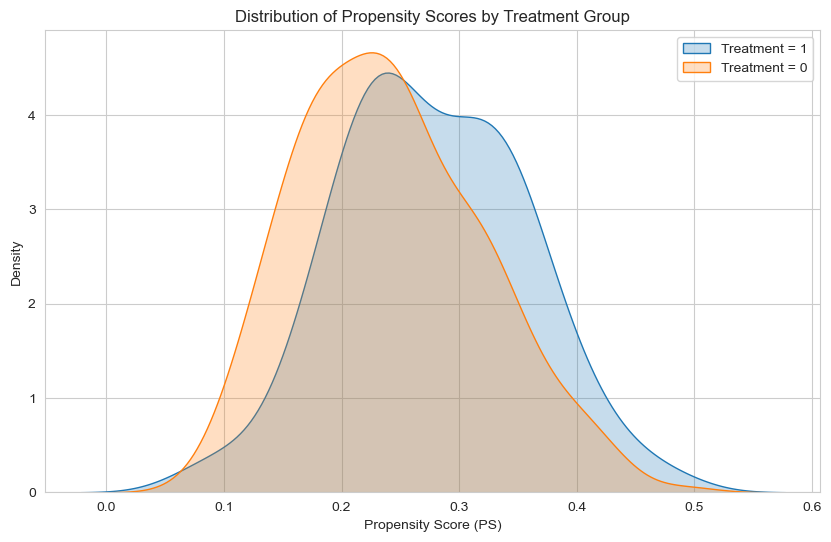

In [4]:
# 4 绘制PS分

import seaborn as sns
import matplotlib.pyplot as plt

# 绘制处理组和对照组的PS分分布图
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['treatment'] == 1]['ps'], label='Treatment = 1', fill=True)  # 使用fill=True代替shade=True
sns.kdeplot(df[df['treatment'] == 0]['ps'], label='Treatment = 0', fill=True)  # 使用fill=True代替shade=True
plt.title('Distribution of Propensity Scores by Treatment Group')
plt.xlabel('Propensity Score (PS)')
plt.ylabel('Density')
plt.legend()
plt.show()

In [5]:
# 5 匹配
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm

# 假设你的数据集是一个DataFrame，名为df
# df = pd.read_csv('your_dataset.csv')

# 计算每个混淆变量的SMD
def calculate_smd(df, treatment_col, confounders):
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]
    smd_dict = {}
    for confounder in confounders:
        smd = (treated[confounder].mean() - control[confounder].mean()) / np.sqrt((treated[confounder].std()**2 + control[confounder].std()**2) / 2)
        smd_dict[confounder] = smd
    return smd_dict

# 计算SMD
smd_before_matching = calculate_smd(df, 'treatment', ['confounder_' + str(i) for i in range(1, 11)])
print("SMD before matching:", smd_before_matching)

SMD before matching: {'confounder_1': -0.041729292261436464, 'confounder_2': 0.05536200921420927, 'confounder_3': -0.05323646634647866, 'confounder_4': -0.09904236377398871, 'confounder_5': -0.023103376587333527, 'confounder_6': -0.10719123667703034, 'confounder_7': 0.10759095100360358, 'confounder_8': 0.09472443246269617, 'confounder_9': 0.089516298726167, 'confounder_10': -0.3637383364875304}


In [6]:
from sklearn.neighbors import NearestNeighbors

# 使用最近邻匹配
nn = NearestNeighbors(n_neighbors=1)
control_group = df[df['treatment'] == 0]
treatment_group = df[df['treatment'] == 1]
nn.fit(control_group[['ps']])  # 使用已经计算好的PS分进行匹配
distances, indices = nn.kneighbors(treatment_group[['ps']])
matched_control_group = control_group.iloc[indices.flatten()]

# 计算匹配后的SMD
smd_after_nn_matching = calculate_smd(pd.concat([treatment_group, matched_control_group]), 'treatment', ['confounder_' + str(i) for i in range(1, 11)])
print("SMD after nearest neighbor matching:", smd_after_nn_matching)

SMD after nearest neighbor matching: {'confounder_1': 0.11743354082378368, 'confounder_2': 0.09152817425177633, 'confounder_3': 0.030590366482800477, 'confounder_4': 0.03076051465418744, 'confounder_5': -0.08763505722488833, 'confounder_6': 0.10292335954524426, 'confounder_7': -0.05667558935146592, 'confounder_8': 0.048354472890030996, 'confounder_9': -0.0890830296741424, 'confounder_10': -0.0883038737248579}


In [7]:
from scipy.spatial.distance import pdist, squareform

# 使用卡洛里匹配
def caliper_matching(df, treatment_col, ps_col, caliper):
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]
    
    # 初始化匹配结果
    matched_control_group = pd.DataFrame()
    
    # 对每个处理组个体进行匹配
    for index, row in treated.iterrows():
        # 计算当前处理组个体与所有对照组个体的PS分数差距
        distances = np.abs(control[ps_col].values - row[ps_col])
        
        # 选择差距小于等于卡洛里的对照组个体
        matched_controls = control[distances <= caliper]
        
        # 如果有多个对照组个体符合条件，随机选择一个
        if not matched_controls.empty:
            matched_control = matched_controls.sample(n=1)
            matched_control_group = pd.concat([matched_control_group, matched_control])
    
    # 确保每个处理组个体只匹配到一个对照组个体，可能需要进一步的处理
    # 这里简单地去掉了重复项，但在实际应用中可能需要更复杂的逻辑
    matched_control_group = matched_control_group.drop_duplicates()
    
    return matched_control_group

# 设置卡洛里宽度
caliper = 0.05
matched_control_group_caliper = caliper_matching(df, 'treatment', 'ps', caliper)

# 计算匹配后的SMD
smd_after_caliper_matching = calculate_smd(pd.concat([treatment_group, matched_control_group_caliper]), 'treatment', ['confounder_' + str(i) for i in range(1, 11)])
print("SMD after caliper matching:", smd_after_caliper_matching)

SMD after caliper matching: {'confounder_1': 0.16574164515461517, 'confounder_2': 0.2514639699335699, 'confounder_3': 0.11379663755750956, 'confounder_4': -0.008625687946150906, 'confounder_5': -0.04926874284953359, 'confounder_6': -0.0869156634350698, 'confounder_7': 0.08408919180122665, 'confounder_8': -0.017726613425808127, 'confounder_9': -0.09648979378361128, 'confounder_10': -0.14581052110178452}


In [8]:
from statsmodels.nonparametric.kernel_regression import KernelReg

# 使用基于核的匹配
def kernel_matching(df, treatment_col, ps_col):
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]
    kernel = KernelReg(control['outcome'].values, control[['ps']].values, var_type='c')
    matched_control_weights = kernel.fit(treated[['ps']].values)[1]
    matched_control_group = pd.DataFrame({col: control[col].values * weight for col, weight in zip(control.columns, matched_control_weights)})
    return matched_control_group

matched_control_group_kernel = kernel_matching(df, 'treatment', 'ps')

# 计算匹配后的SMD
smd_after_kernel_matching = calculate_smd(pd.concat([treatment_group, matched_control_group_kernel]), 'treatment', ['confounder_' + str(i) for i in range(1, 11)])
print("SMD after kernel matching:", smd_after_kernel_matching)

SMD after kernel matching: {'confounder_1': 0.02199407721067029, 'confounder_2': 0.10199652329707716, 'confounder_3': -0.027674458463511933, 'confounder_4': -0.09706463225009994, 'confounder_5': 0.015621744096201587, 'confounder_6': -0.02519321732985035, 'confounder_7': -0.030590645417512247, 'confounder_8': 0.058676446630499174, 'confounder_9': 0.1899919792214549, 'confounder_10': 0.0008567660810298864}


In [9]:
def calculate_variance_ratio(df, treatment_col, confounders):
    treated = df[df[treatment_col] == 1]
    control = df[df[treatment_col] == 0]
    variance_ratio_dict = {}
    for confounder in confounders:
        variance_ratio = treated[confounder].var() / control[confounder].var()
        variance_ratio_dict[confounder] = variance_ratio
    return variance_ratio_dict

# 计算匹配前后的方差比
variance_ratio_before_matching = calculate_variance_ratio(df, 'treatment', ['confounder_' + str(i) for i in range(1, 11)])
variance_ratio_after_nn_matching = calculate_variance_ratio(pd.concat([treatment_group, matched_control_group]), 'treatment', ['confounder_' + str(i) for i in range(1, 11)])
variance_ratio_after_caliper_matching = calculate_variance_ratio(pd.concat([treatment_group, matched_control_group_caliper]), 'treatment', ['confounder_' + str(i) for i in range(1, 11)])
variance_ratio_after_kernel_matching = calculate_variance_ratio(pd.concat([treatment_group, matched_control_group_kernel]), 'treatment', ['confounder_' + str(i) for i in range(1, 11)])

print("Variance ratio before matching:", variance_ratio_before_matching)
print("Variance ratio after nearest neighbor matching:", variance_ratio_after_nn_matching)
print("Variance ratio after caliper matching:", variance_ratio_after_caliper_matching)
print("Variance ratio after kernel matching:", variance_ratio_after_kernel_matching)

Variance ratio before matching: {'confounder_1': 0.9980405707245132, 'confounder_2': 0.8044320148564995, 'confounder_3': 1.471149288212266, 'confounder_4': 1.2367892253900172, 'confounder_5': 0.9594650249485263, 'confounder_6': 0.6007359980293571, 'confounder_7': 1.0890111108932774, 'confounder_8': 0.949174800315599, 'confounder_9': 1.0640022388741364, 'confounder_10': 1.0956749931249927}
Variance ratio after nearest neighbor matching: {'confounder_1': 0.8335731439831048, 'confounder_2': 0.7858015051688216, 'confounder_3': 1.9110618447881367, 'confounder_4': 1.058462105671786, 'confounder_5': 1.0380734981573476, 'confounder_6': 0.7450588705427349, 'confounder_7': 1.0401739111580568, 'confounder_8': 0.7483988983581877, 'confounder_9': 1.1726124528169357, 'confounder_10': 1.0572769071652828}
Variance ratio after caliper matching: {'confounder_1': 1.0180084478990408, 'confounder_2': 0.9443326089883562, 'confounder_3': 1.5151898836868194, 'confounder_4': 1.356249790731336, 'confounder_5': 

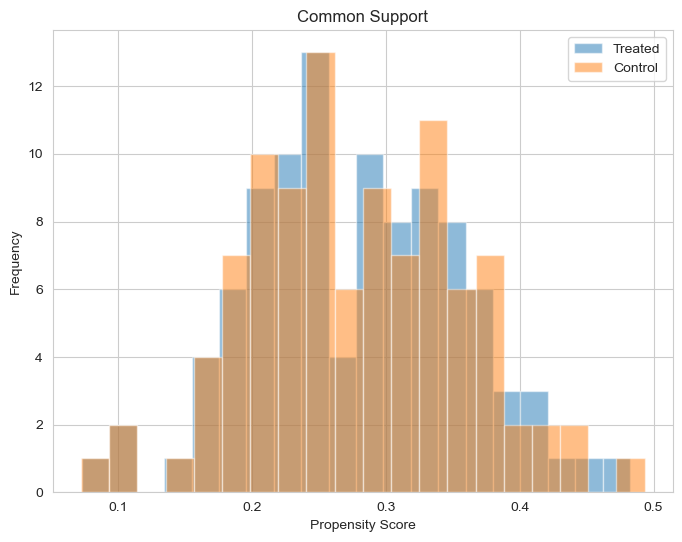

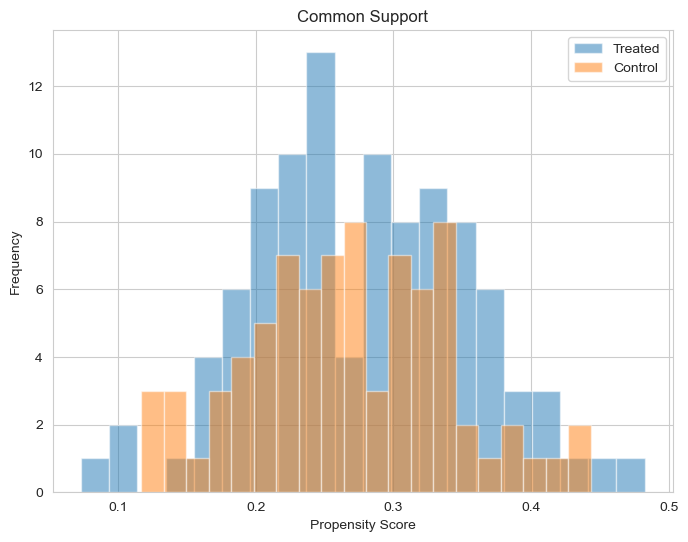

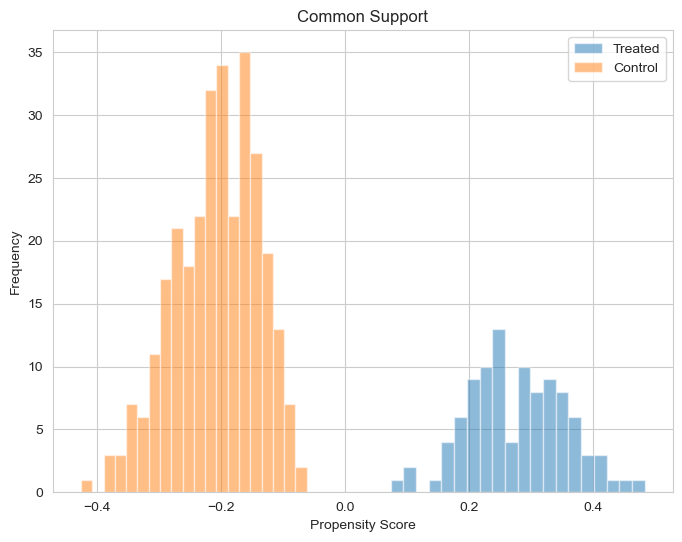

In [10]:
# 对于每种匹配方法，计算并绘制共同支持

def plot_common_support(treated, control, ps_col):
    plt.figure(figsize=(8, 6))
    plt.hist(treated[ps_col], bins=20, alpha=0.5, label='Treated')
    plt.hist(control[ps_col], bins=20, alpha=0.5, label='Control')
    plt.legend()
    plt.xlabel('Propensity Score')
    plt.ylabel('Frequency')
    plt.title('Common Support')
    plt.show()

# 最近邻匹配
plot_common_support(treatment_group, matched_control_group, 'ps')
# 卡洛里匹配
plot_common_support(treatment_group, matched_control_group_caliper, 'ps')
# 基于核的匹配
plot_common_support(treatment_group, matched_control_group_kernel, 'ps')

In [11]:
# 6 估计

# 直接估计
def estimate_causal_effect_matching(treated, matched_control):
    return treated['outcome'].mean() - matched_control['outcome'].mean()

# 对于每种匹配方法，估计因果效应
effect_nn_matching = estimate_causal_effect_matching(treatment_group, matched_control_group)
effect_caliper_matching = estimate_causal_effect_matching(treatment_group, matched_control_group_caliper)
effect_kernel_matching = estimate_causal_effect_matching(treatment_group, matched_control_group_kernel)

print("Causal effect estimated by nearest neighbor matching:", effect_nn_matching)
print("Causal effect estimated by caliper matching:", effect_caliper_matching)
print("Causal effect estimated by kernel matching:", effect_kernel_matching)

Causal effect estimated by nearest neighbor matching: 0.020000000000000018
Causal effect estimated by caliper matching: -0.09500000000000003
Causal effect estimated by kernel matching: 0.8420494841915978


In [15]:
def estimate_causal_effect_regression_matched(matched_data, treatment_col, outcome_col):
    X = sm.add_constant(matched_data[[treatment_col]])
    model = sm.OLS(matched_data[outcome_col], X).fit()
    return model.params[treatment_col]

# 对于每种匹配方法，使用回归估计因果效应
effect_nn_matching_regression = estimate_causal_effect_regression_matched(pd.concat([treatment_group, matched_control_group]), 'treatment', 'outcome')
effect_caliper_matching_regression = estimate_causal_effect_regression_matched(pd.concat([treatment_group, matched_control_group_caliper]), 'treatment', 'outcome')
effect_kernel_matching_regression = estimate_causal_effect_regression_matched(pd.concat([treatment_group, matched_control_group_kernel]), 'treatment', 'outcome')

print("Causal effect estimated by regression after nearest neighbor matching:", effect_nn_matching_regression)
print("Causal effect estimated by regression after caliper matching:", effect_caliper_matching_regression)
print("Causal effect estimated by regression after kernel matching:", effect_kernel_matching_regression)

Causal effect estimated by regression after nearest neighbor matching: 0.01999999999999999
Causal effect estimated by regression after caliper matching: -0.095
Causal effect estimated by regression after kernel matching: 0.842049484191598


In [17]:
def estimate_causal_effect_iptw_matched(matched_data, treatment_col, outcome_col, ps_col):
    # 计算每个个体的IPTW权重
    weights = (matched_data[treatment_col] / matched_data[ps_col]) + ((1 - matched_data[treatment_col]) / (1 - matched_data[ps_col]))
    
    # 使用加权最小二乘法估计因果效应
    X = sm.add_constant(matched_data[[treatment_col]])
    model = sm.WLS(matched_data[outcome_col], X, weights=weights).fit()
    return model.params[treatment_col]

# 对于每种匹配方法，使用IPTW估计因果效应
effect_nn_matching_iptw = estimate_causal_effect_iptw_matched(pd.concat([treatment_group, matched_control_group]), 'treatment', 'outcome', 'ps')
effect_caliper_matching_iptw = estimate_causal_effect_iptw_matched(pd.concat([treatment_group, matched_control_group_caliper]), 'treatment', 'outcome', 'ps')
effect_kernel_matching_iptw = estimate_causal_effect_iptw_matched(pd.concat([treatment_group, matched_control_group_kernel]), 'treatment', 'outcome', 'ps')

print("Causal effect estimated by IPTW after nearest neighbor matching:", effect_nn_matching_iptw)
print("Causal effect estimated by IPTW after caliper matching:", effect_caliper_matching_iptw)
print("Causal effect estimated by IPTW after kernel matching:", effect_kernel_matching_iptw)

Causal effect estimated by IPTW after nearest neighbor matching: 0.04170179897409344
Causal effect estimated by IPTW after caliper matching: -0.0786967351596837
Causal effect estimated by IPTW after kernel matching: 0.8602474371308058
